---

<h1><center>Linear regression and Feature selection </center></h1>

---

In this lab we will use linear regression to predict cancer mortality rates based on data obtained from the American Community Survey of the [U.S. Census Bureau](https://www.census.gov/). The lab has four parts. In part 1 you will load the data and do basic manipulations using [pandas](https://pandas.pydata.org/docs/index.html). In part 2 you will perform basic linear regression on the full feature set. In part 3 you will compute confidence intervals and perform hypothesis tests on the paramters from part 2. Then in part 4 you will run the forward and backward stepwise feature selection algorithms and estimate the performance of the resulting model using a test dataset.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

C:\Users\brian\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<h1><font color='purple'> Part 1:  Loading and cleaning the data</font></h1>

## 1.1 Load the data into a pandas DataFrame

See a description of the data [here](https://data.world/nrippner/ols-regression-challenge).

You can obtain information about the data using these pandas commands:
+ `data.head()` to see the first 5 rows of the DataFrame.
+ `data.tail()` to see the last 5 rows of the DataFrame.
+ `data.shape` is the tuple (number of rows, number of columns).
+ `data.columns` contains the column labels.
+ `data.index` contains the row labels.

In [2]:
data = pd.read_csv('cancerdata.csv')

## 1.2 Inspect columns

Run `data.info()` and note:
 a) which columns are non-numeric (Dtype=object), and
 b) which have null entries (Non-Null Count<3047).

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target_deathrate         3047 non-null   float64
 1   incidencerate            3047 non-null   float64
 2   medincome                3047 non-null   int64  
 3   povertypercent           3047 non-null   float64
 4   binnedinc                3047 non-null   object 
 5   medianage                3047 non-null   float64
 6   geography                3047 non-null   object 
 7   avghouseholdsize         3047 non-null   float64
 8   percentmarried           3047 non-null   float64
 9   pctnohs18_24             3047 non-null   float64
 10  pcths18_24               3047 non-null   float64
 11  pctsomecol18_24          762 non-null    float64
 12  pctbachdeg18_24          3047 non-null   float64
 13  pcths25_over             3047 non-null   float64
 14  pctbachdeg25_over       

## 1.3 Discard non-numerical columns

Remove the two columns with non-numeric data.
Hints:
+ `data.dtypes` lists the data types for each column.
+ You can construct a boolean indicator array of non-numeric colums with `data.dtypes=='object'`.
+ Use that array to index `data.columns`
+ Use [`data.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) to remove the selected columns

In [4]:
ind = data.dtypes=='object'
print(ind)

drop_cols = data.columns[ind]
print(drop_cols)

data = data.drop(columns=(drop_cols))
data.info()

target_deathrate           False
incidencerate              False
medincome                  False
povertypercent             False
binnedinc                   True
medianage                  False
geography                   True
avghouseholdsize           False
percentmarried             False
pctnohs18_24               False
pcths18_24                 False
pctsomecol18_24            False
pctbachdeg18_24            False
pcths25_over               False
pctbachdeg25_over          False
pctemployed16_over         False
pctunemployed16_over       False
pctprivatecoverage         False
pctprivatecoveragealone    False
pctempprivcoverage         False
pctpubliccoverage          False
pctpubliccoveragealone     False
pctwhite                   False
pctblack                   False
pctasian                   False
pctotherrace               False
pctmarriedhouseholds       False
birthrate                  False
dtype: bool
Index(['binnedinc', 'geography'], dtype='object')
<class 'pandas

## 1.4 Discard columns where more than 10% of values are nan

Hints:
+ [`data.dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
+ `axis` ... we are dropping columns
+ `thresh` ... The condition for dropping a column is that it has less than `round(0.9*data.shape[0])` non-nans.


In [5]:
data.shape[0]

thresh = round(0.9*data.shape[0])
print(thresh)

data = data.dropna(axis = 1, thresh = thresh) #axis = 1 drop columns

2742


## 1.5 Drop all rows that contain one or more nans.

Hint: You can again use `data.dropna` for this.

In [6]:
thresh = round(data.shape[1])
data = data.dropna(axis = 0, thresh = thresh)
data.shape[0]

2895

## 1.6 Inspect correlations

Next we'll look at the correlation coefficients between each of the features and the target variable `target_deathrate`.

1) Use `data.corr()` to build the correlations matrix.
2) Inspect the column (or row) corresponding to `target_deathrate`.
3) Rank (i.e. sort) the features from most to least correlated with the output. This ranking is in terms of the absolute value of the correlation coefficient.
4) Save the top 5 correlated features to `top_5_corr`. `top_5_corr` should be a numpy array with shape `(5,)`.

Hints:
+ [`abs`](https://pandas.pydata.org/docs/reference/api/pandas.Series.abs.html)
+ [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html)
+ [`to_numpy`](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_numpy.html)

In [8]:
# correlation matrix
C = data.corr()

# vector correlations between the features and target_deathrate
corr_target = abs(C.loc[:,"target_deathrate"])

#print(corr_target)

# sorted corr_target_sort
corr_target_sort = corr_target.sort_values(ascending=False) #sort descending

print(corr_target_sort)

# top 5 correlations with target_deathrate
top_5_sort = corr_target_sort.iloc[1:6] #sort top 5
print(top_5_sort)
top_5_sort = top_5_sort.keys().values.tolist() #get column names

print(top_5_sort)

targetdeathrate = corr_target_sort.iloc[0:1]
targetdeathrate = targetdeathrate.keys().values.tolist()
print(targetdeathrate)

target_deathrate          1.000000
pctbachdeg25_over         0.482594
pctpubliccoveragealone    0.448087
incidencerate             0.428787
medincome                 0.426784
povertypercent            0.425083
pctemployed16_over        0.412046
pcths25_over              0.403842
pctpubliccoverage         0.402141
pctprivatecoverage        0.385420
pctunemployed16_over      0.373750
pctmarriedhouseholds      0.286233
pctbachdeg18_24           0.285941
pctempprivcoverage        0.264430
pcths18_24                0.261246
percentmarried            0.257639
pctblack                  0.252774
pctotherrace              0.189770
pctasian                  0.186464
pctwhite                  0.165104
birthrate                 0.088058
pctnohs18_24              0.080009
avghouseholdsize          0.040009
medianage                 0.001208
Name: target_deathrate, dtype: float64
pctbachdeg25_over         0.482594
pctpubliccoveragealone    0.448087
incidencerate             0.428787
medincome       

## 1.7 Scatter plot

Make a scatter plot of the data with the most correlated feature along the x axis, and the target along the y axis.

Hint: You can use the plotting function attached to the DataFrame: [data.plot(kind='scatter',x=..., y=...)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

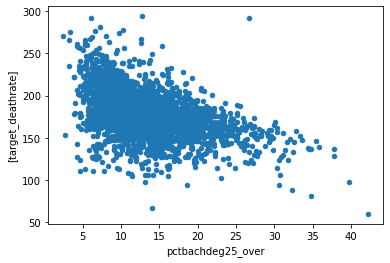

In [9]:
data.plot(kind='scatter',x=top_5_sort[0],y=targetdeathrate)

---

<h1><font color='purple'> Part 2: Linear regression - Point estimates</font></h1>

## 2.1 Extract data matrices

The next cell extracts the `X` and `Y` matrices from `data`. It also makes a list of `features`, and defines dimensions `N` and `D`.

In [10]:
X = data.drop(columns='target_deathrate').values
features = data.columns.values
features = features[features!='target_deathrate']
Y = data['target_deathrate'].values
print(X.shape)
print(Y.shape)
D = X.shape[1]
N = Y.shape[0]
print(N)
print(D)

(2895, 23)
(2895,)
2895
23


## 2.2 Center the inputs

## $\mathbf{\bar{X}} = \text{mean}(\mathbf{X})$
## $\Phi=\mathbf{X}-\mathbf{\bar{X}}$

Compute the column-wise means `Xbar` and subtract them from `X` to obtain `Phi`. Hint: Use `X.mean(axis=...)`. Should it be `axis=0` or `axis=1`? Check that the column-wise means of `Phi` equal zero (to machine precision). 

In [11]:
Xbar = X.mean(axis=0)
Phi = X-Xbar
Phi.shape

(2895, 23)

## 2.3 Compute the intercept term 

## $\theta_0 = \text{mean}(\mathbf{Y})$

In [12]:
theta0 = Y.mean()

## 2.4 Center the output

## $\mathbf{\tilde{Y}} = \mathbf{Y} - \theta_0$

In [13]:
Ytilde = Y - theta0

## 2.5 Compute $V=(\Phi^T \Phi)^{-1}$

Hints:
+ numpy's @ operator and matrix transposition (`Phi.T`). See [this](https://numpy.org/devdocs/user/numpy-for-matlab-users.html) summary of the key differences between numpy and Matlab.
+ [np.linalg.inv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)


In [14]:
V = np.linalg.inv(Phi.T@Phi)

## 2.6 Compute the least squares estimates of the parameters

### ${\underline\theta} = (\Phi^T\Phi)^{-1}\Phi^{T} \mathbf{\tilde{Y}}$

In [15]:
theta = V@Phi.T@Ytilde

## 2.7 Compute predictions for each of the samples

### $\mathbf{\hat{Y}} = \theta_0 + \Phi\underline\theta$


In [16]:
Yhat = theta0 + Phi@theta

---

<h1><font color='purple'> Part 3: Parameter uncertainty and hypothesis test</font></h1>

## 3.1 Compute the standard deviation of the output

### $\hat\sigma_Y = \sqrt{ \frac{1}{N-D-1} \sum_{i=1}^{N}(y_i-\hat{y}_i)^2 }$

In [18]:
sigmahatY = np.sqrt(1/(N-D-1)*sum((Y-Yhat)**2))

## 3.2 Compute the standard deviations of the parameter estimates

### $\sigma_i = Std(\hat\theta_i) = \hat\sigma_Y \sqrt{ v_i } $

Here $v_i$ is the $i$'th diagonal component of $V$.

In [19]:
v = np.diag(V)
sigma_theta = sigmahatY*np.sqrt(v)

## 3.3 Conduct a hypothesis test on each of the parameters, with the null hypothesis that the parameter value is zero. Use a significance level of $\alpha=0.05$.

In [20]:
alpha = 0.05

### 3.3.1 Compute Z for each parameter

### $Z_i = \hat\theta_i/\sigma_i$

In [21]:
Z = theta/sigma_theta

### 3.3.2. Compute the p-value for each parameter

### $p_i = 2\: \Phi_{\mathcal{N}}(-|Z_i|)$

In [22]:
p = 2*stats.norm.cdf(-abs(Z))
print(p)

[2.68832634e-132 6.59357555e-001 7.12544118e-002 5.23726380e-001
 4.20758498e-001 2.18136252e-012 6.53365715e-004 2.62995517e-004
 2.96567574e-001 1.68555128e-004 1.17857663e-014 8.23945617e-010
 3.48105456e-001 6.44277829e-004 7.79129732e-005 2.48525449e-007
 8.63753049e-005 2.67867102e-002 2.63299608e-001 3.76173367e-001
 4.99872942e-013 1.25869879e-014 1.87389273e-005]


### 3.3.3 Create a boolean mask indicating features that were deemed influential by the hypothesis test (H0 was rejected)

Done already.

In [23]:
ind_influential = p<alpha

### 3.4 Parameters table.
Make a DataFrame with one row per parameter. The index of the table should be the parameter names. The columns should be:
+ `theta`: the point estimate of the parameter.
+ `stddev`: the estiuamted standard deviation of the parameters.
+ `Z`: Z scores computed in part 3.3.1
+ `p`: p-values compute in part 3.3.2
+ `influential`: the boolean indicator from part 3.3.3.

Done already.

In [24]:
lr_params = pd.DataFrame(index=features,
             data={'theta':theta,
                   'stddev':sigma_theta,
                   'Z':Z,
                   'p':p,
                   'influential':ind_influential})

lr_params

,theta,stddev,Z,p,influential
incidencerate,0.187506,0.007661,24.475587,2.688326e-132,True
medincome,0.000036,0.000082,0.440800,6.593576e-01,False
povertypercent,0.291682,0.161699,1.803853,7.125441e-02,False
medianage,-0.005219,0.008185,-0.637612,5.237264e-01,False
avghouseholdsize,0.797012,0.989947,0.805106,4.207585e-01,False
percentmarried,1.166145,0.166061,7.022370,2.181363e-12,True
pctnohs18_24,-0.194668,0.057114,-3.408435,6.533657e-04,True
pcths18_24,0.183444,0.050269,3.649261,2.629955e-04,True
pctbachdeg18_24,-0.114888,0.110064,-1.043822,2.965676e-01,False
pcths25_over,0.369317,0.098170,3.762007,1.685551e-04,True


## 3.5 Sort the parameters table by p-value

Create a new DataFrame called `lr_params_sorted` by sorting the values in ascending order, according to p-values.

Hint: [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)

In [25]:
lr_params_sorted = lr_params.sort_values(by=['p'],axis=0, ascending=True)

## 3.6 Bar plot

The bar plot below shows the parameter values along with their 95% (2$\sigma$) confidence intervals. Influential fetaures are showns in green, non-influential features are shown in red.

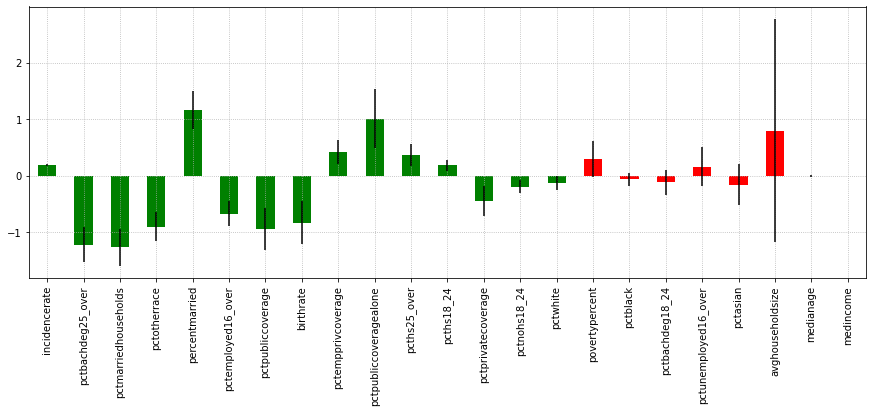

In [26]:
color = np.array(['g' for i in range(D)])
color[~lr_params_sorted['influential']] = 'r'

lr_params_sorted.plot(kind='bar',
                y='theta',
                yerr=2*lr_params_sorted['stddev'],
                figsize=(15,5),
                color=color,
                legend=False)
plt.grid(linestyle=':')

## 3.7 Build list of features to keep

Extract the names of influential features from `lr_params_sorted` and store them in `features` (overwrite the previous values). `features` should be a numpy array with shape `(15,)`.

In [28]:
features = lr_params_sorted["influential"]

features = features.iloc[0:15]
features = features.keys().values.tolist()
features = np.array(features)
print(features)
print(features.shape)

['incidencerate' 'pctbachdeg25_over' 'pctmarriedhouseholds' 'pctotherrace'
 'percentmarried' 'pctemployed16_over' 'pctpubliccoverage' 'birthrate'
 'pctempprivcoverage' 'pctpubliccoveragealone' 'pcths25_over' 'pcths18_24'
 'pctprivatecoverage' 'pctnohs18_24' 'pctwhite']
(15,)


## 3.8 Create a new DataFrame with only the chosen features

Done already. Notice that the target variable is now called `Y`.

In [29]:
D = data[features].copy()
D['Y'] = data['target_deathrate']
D.head()

,incidencerate,pctbachdeg25_over,pctmarriedhouseholds,pctotherrace,percentmarried,pctemployed16_over,pctpubliccoverage,birthrate,pctempprivcoverage,pctpubliccoveragealone,pcths25_over,pcths18_24,pctprivatecoverage,pctnohs18_24,pctwhite,Y
0,489.8,19.6,52.856076,1.843479,52.5,51.9,32.9,6.118831,41.6,14.0,23.2,39.5,75.1,11.5,81.780529,164.9
1,411.6,22.7,45.372500,3.741352,44.5,55.9,31.1,4.333096,43.6,15.3,26.0,22.4,70.2,6.1,89.228509,161.3
2,349.7,16.0,54.444868,2.747358,54.2,45.9,42.1,3.729488,34.9,21.1,29.0,36.6,63.7,24.0,90.922190,174.7
3,430.4,9.3,51.021514,1.362643,52.7,48.3,45.3,4.603841,35.0,25.0,31.6,41.2,58.4,20.2,91.744686,194.8
4,350.1,15.0,54.027460,0.492135,57.8,48.2,44.0,6.796657,35.1,22.7,33.4,43.0,61.6,14.9,94.104024,144.4
